### Generate some statistics files

In [1]:
import analysis.stats_utils as stats_utils
# from analysis.viz_utils_v2 import visualizer
from analysis.viz_utils import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/home/zhijie/terasim/TeraSim-NDE-ITE/applications/driving_intelligence_test/output"
# exp_repo = "/home/zhijie/terasim/TeraSim-NDE-ITE/output"
exp_name="cosim_test_local"

experiment_record_repo = f"{exp_repo}/{exp_name}/raw_data"
export_stat_dir = f"{exp_repo}/{exp_name}/processed_data"

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [2]:
stats_utils.export_to_csv_aws(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 1/1 [00:00<00:00, 421.79it/s]


  0%|          | 0/601 [00:00<?, ?it/s]

0

In [10]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#### Import statistics of each experiment

In [12]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
cosim_test_local_0_1,1363.1,1193,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,34914.337819,601.313321,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN


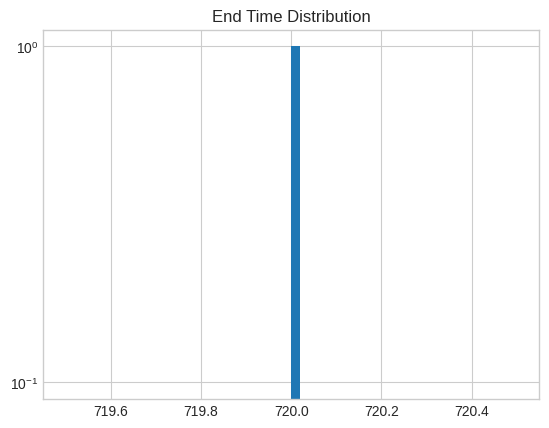

In [13]:
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [15]:
warm_up_time = 900
estimated_end_time = warm_up_time + 900

has_collision = (exp_stats_info['crash_veh_1'] == "CAV") | (exp_stats_info['crash_veh_2'] == "CAV")
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

KeyError: 'warmup_time'

**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [159]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - 900).sum()
# all_routes = np.load(f"{export_stat_dir}/cav_traveling_distance_list.npy").sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
# print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
# print(f"Overall route length: {all_routes:.2f} m")
# print(f"m/s: {all_routes/all_time}")
# print(f"Overall route length: {all_routes/mile_to_m} mile")
# print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
# print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 601
Number of collision: 36
Importance summation: 2.4069952996670145
Max weight: 1.3117442125185899, Min weight: 5.074823397461178e-06
raw collision rate: 0.059900166389351084
adjusted collision rate (importance): 0.0040049838596788925
Collision due to traffic light ignorance: 0
Overall maneuvers: 3837
Collision without negligence: 2
Maximum time between collision and negligence: 2.70 s

Overall time: -108180.00 s
Maneuvers per second: -0.035468663338879644


In [160]:
exp_stats_info.head()

,,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
cosim_test_local_0_1,1363.1,1193,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,34914.337819,601.313321,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN


In [161]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1800)]
a

,,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
cosim_test_local_0_1,1363.1,1193,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,34914.337819,601.313321,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cosim_test_local_0_596,1445.4,993,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,101966.018120,2775.432946,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_597,1328.7,984,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,68265.664639,4292.945605,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_599,1550.4,1181,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,70243.314155,4642.450564,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_600,1516.3,1042,720,NaN,NaN,-0.130942,30,NaN,-1.0,NaN,NaN,105388.061821,4396.494751,NaN,NaN,NaN,None,-10.0,NaN


### Crash Distribution (with negligence)

In [162]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1800) & (exp_stats_info["neg_time_diff"]  > 0)]

,,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [163]:
exp_stats_info.head()

,,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
cosim_test_local_0_1,1363.1,1193,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,34914.337819,601.313321,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_2,1359.1,1065,720,NaN,NaN,-0.056742,13,NaN,-1.0,NaN,NaN,48394.572790,898.780712,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_3,1519.5,1132,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,77169.397664,2836.094602,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_4,1421.0,1108,720,NaN,NaN,-0.000000,0,NaN,-1.0,NaN,NaN,59589.184271,2833.284692,NaN,NaN,NaN,None,-10.0,NaN
cosim_test_local_0_5,1326.6,1030,720,NaN,NaN,-0.004365,1,NaN,-1.0,NaN,NaN,60455.163220,1702.392321,NaN,NaN,NaN,None,-10.0,NaN


In [164]:
# collision: negligence-caused no negligence caused (SUMO)
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))
print(len(exp_stats_info[has_collision]))

34 2
36


Negligence caused distribution

In [165]:
neg_caused_collision["lane_id"].value_counts()
# print(len(neg_caused_collision))

EG_1_3_1_1      23
EG_17_1_1_0      2
EG_9_1_1_0       2
:NODE_17_1_0     2
:NODE_7_0_1      1
:NODE_18_2_0     1
:NODE_26_1_0     1
EG_14_2_1_0      1
EG_16_23_1_0     1
Name: lane_id, dtype: int64

No negligence caused distribution

In [166]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

:NODE_22_3_0     1
:NODE_18_15_0    1
Name: lane_id, dtype: int64
2


### Crash Distribution (All)

In [167]:
def crash_distribution(all_stats_info, feat_name):
    crash_type_dist = all_stats_info.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [168]:
all_stats_info = exp_stats_info.copy()[has_collision]
all_stats_info["exp_importance"] = np.power(10, -all_stats_info["importance"])

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
all_stats_info["location"] = list(map(get_type_func, all_stats_info["location_type"]))
all_stats_info["collision"] = list(map(get_type_func, all_stats_info["collision_type"]))


crash_type_dist = crash_distribution(all_stats_info, "collision")
crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,12,0.000067,0.019967,1.110965e-07
1,freeway,sideswipe,11,0.000063,0.018303,1.045143e-07
2,intersection,angle,1,0.000010,0.001664,1.630610e-08
3,intersection,head,1,1.311744,0.001664,2.182603e-03
4,intersection,rear,7,0.000425,0.011647,7.070317e-07
5,roundabout,angle,1,1.094669,0.001664,1.821413e-03
6,roundabout,rear,3,0.000018,0.004992,2.952657e-08


In [169]:
print(all_stats_info)

                               name  end_time crash_veh_1 crash_veh_2  \
cosim_test_local_0_26  1319.7  1123       720         CAV    BV_22.16   
cosim_test_local_0_30  979.5    932       720         CAV    BV_21.56   
cosim_test_local_0_48  1169.3  1144       720    BV_17.52         CAV   
cosim_test_local_0_78  1063.0  1043       720    BV_22.10         CAV   
cosim_test_local_0_102 1024.5  1005       720     BV_8.71         CAV   
cosim_test_local_0_135 962.9    943       720     BV_8.65         CAV   
cosim_test_local_0_148 1097.8  1087       720     BV_8.53         CAV   
cosim_test_local_0_154 1184.2  1174       720     BV_8.68         CAV   
cosim_test_local_0_198 1165.0  1002       720         CAV     BV_3.13   
cosim_test_local_0_229 1180.5   947       720    BV_23.39         CAV   
cosim_test_local_0_230 1023.9   995       720     BV_8.59         CAV   
cosim_test_local_0_250 1196.1  1149       720    BV_17.65         CAV   
cosim_test_local_0_256 1156.5  1129       720    BV

In [102]:
# location_distribution = crash_type_dist.groupby("location").sum()
# proportion = location_distribution["exp_importance"]
# print(proportion)

# plt.figure(figsize=(20, 10))
# plt.subplot(3, 1, 1)
# plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# # plt.bar(proportion.index, values=proportion)
# plt.title("Autoware AI")
# plt.subplot(3, 1, 2)
# true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
# plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# # plt.bar(proportion.index, values=true_dist)
# plt.title("ground truth")|

In [170]:
def pie_chart_plot(df, exp_name, feat_name,value_name="importance_rate"):
    mark = df["location"] == exp_name
    labels = df[mark][feat_name]
    values = df[mark][value_name]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{exp_name}')
    # plt.legend(labels)

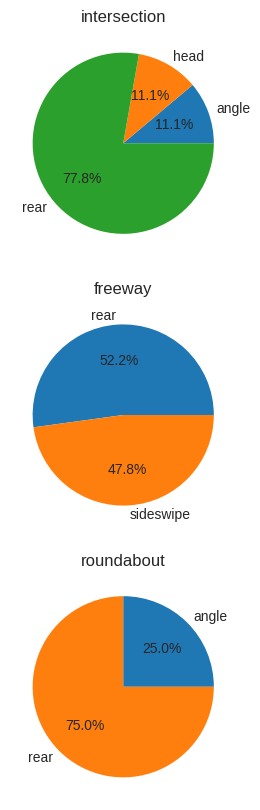

In [171]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision", "collision_rate")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision", "collision_rate")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision", "collision_rate")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

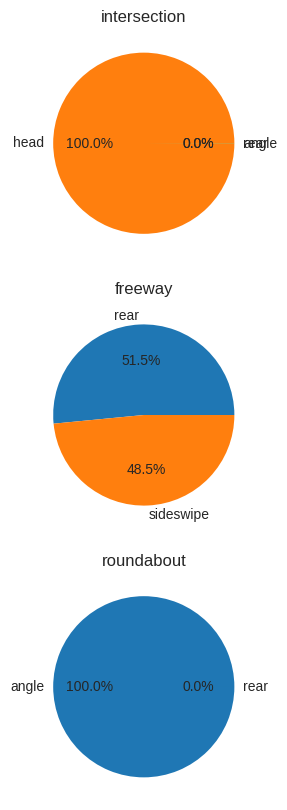

In [172]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

### Crash Severity Distribution

Text(0, 0.5, 'Count')

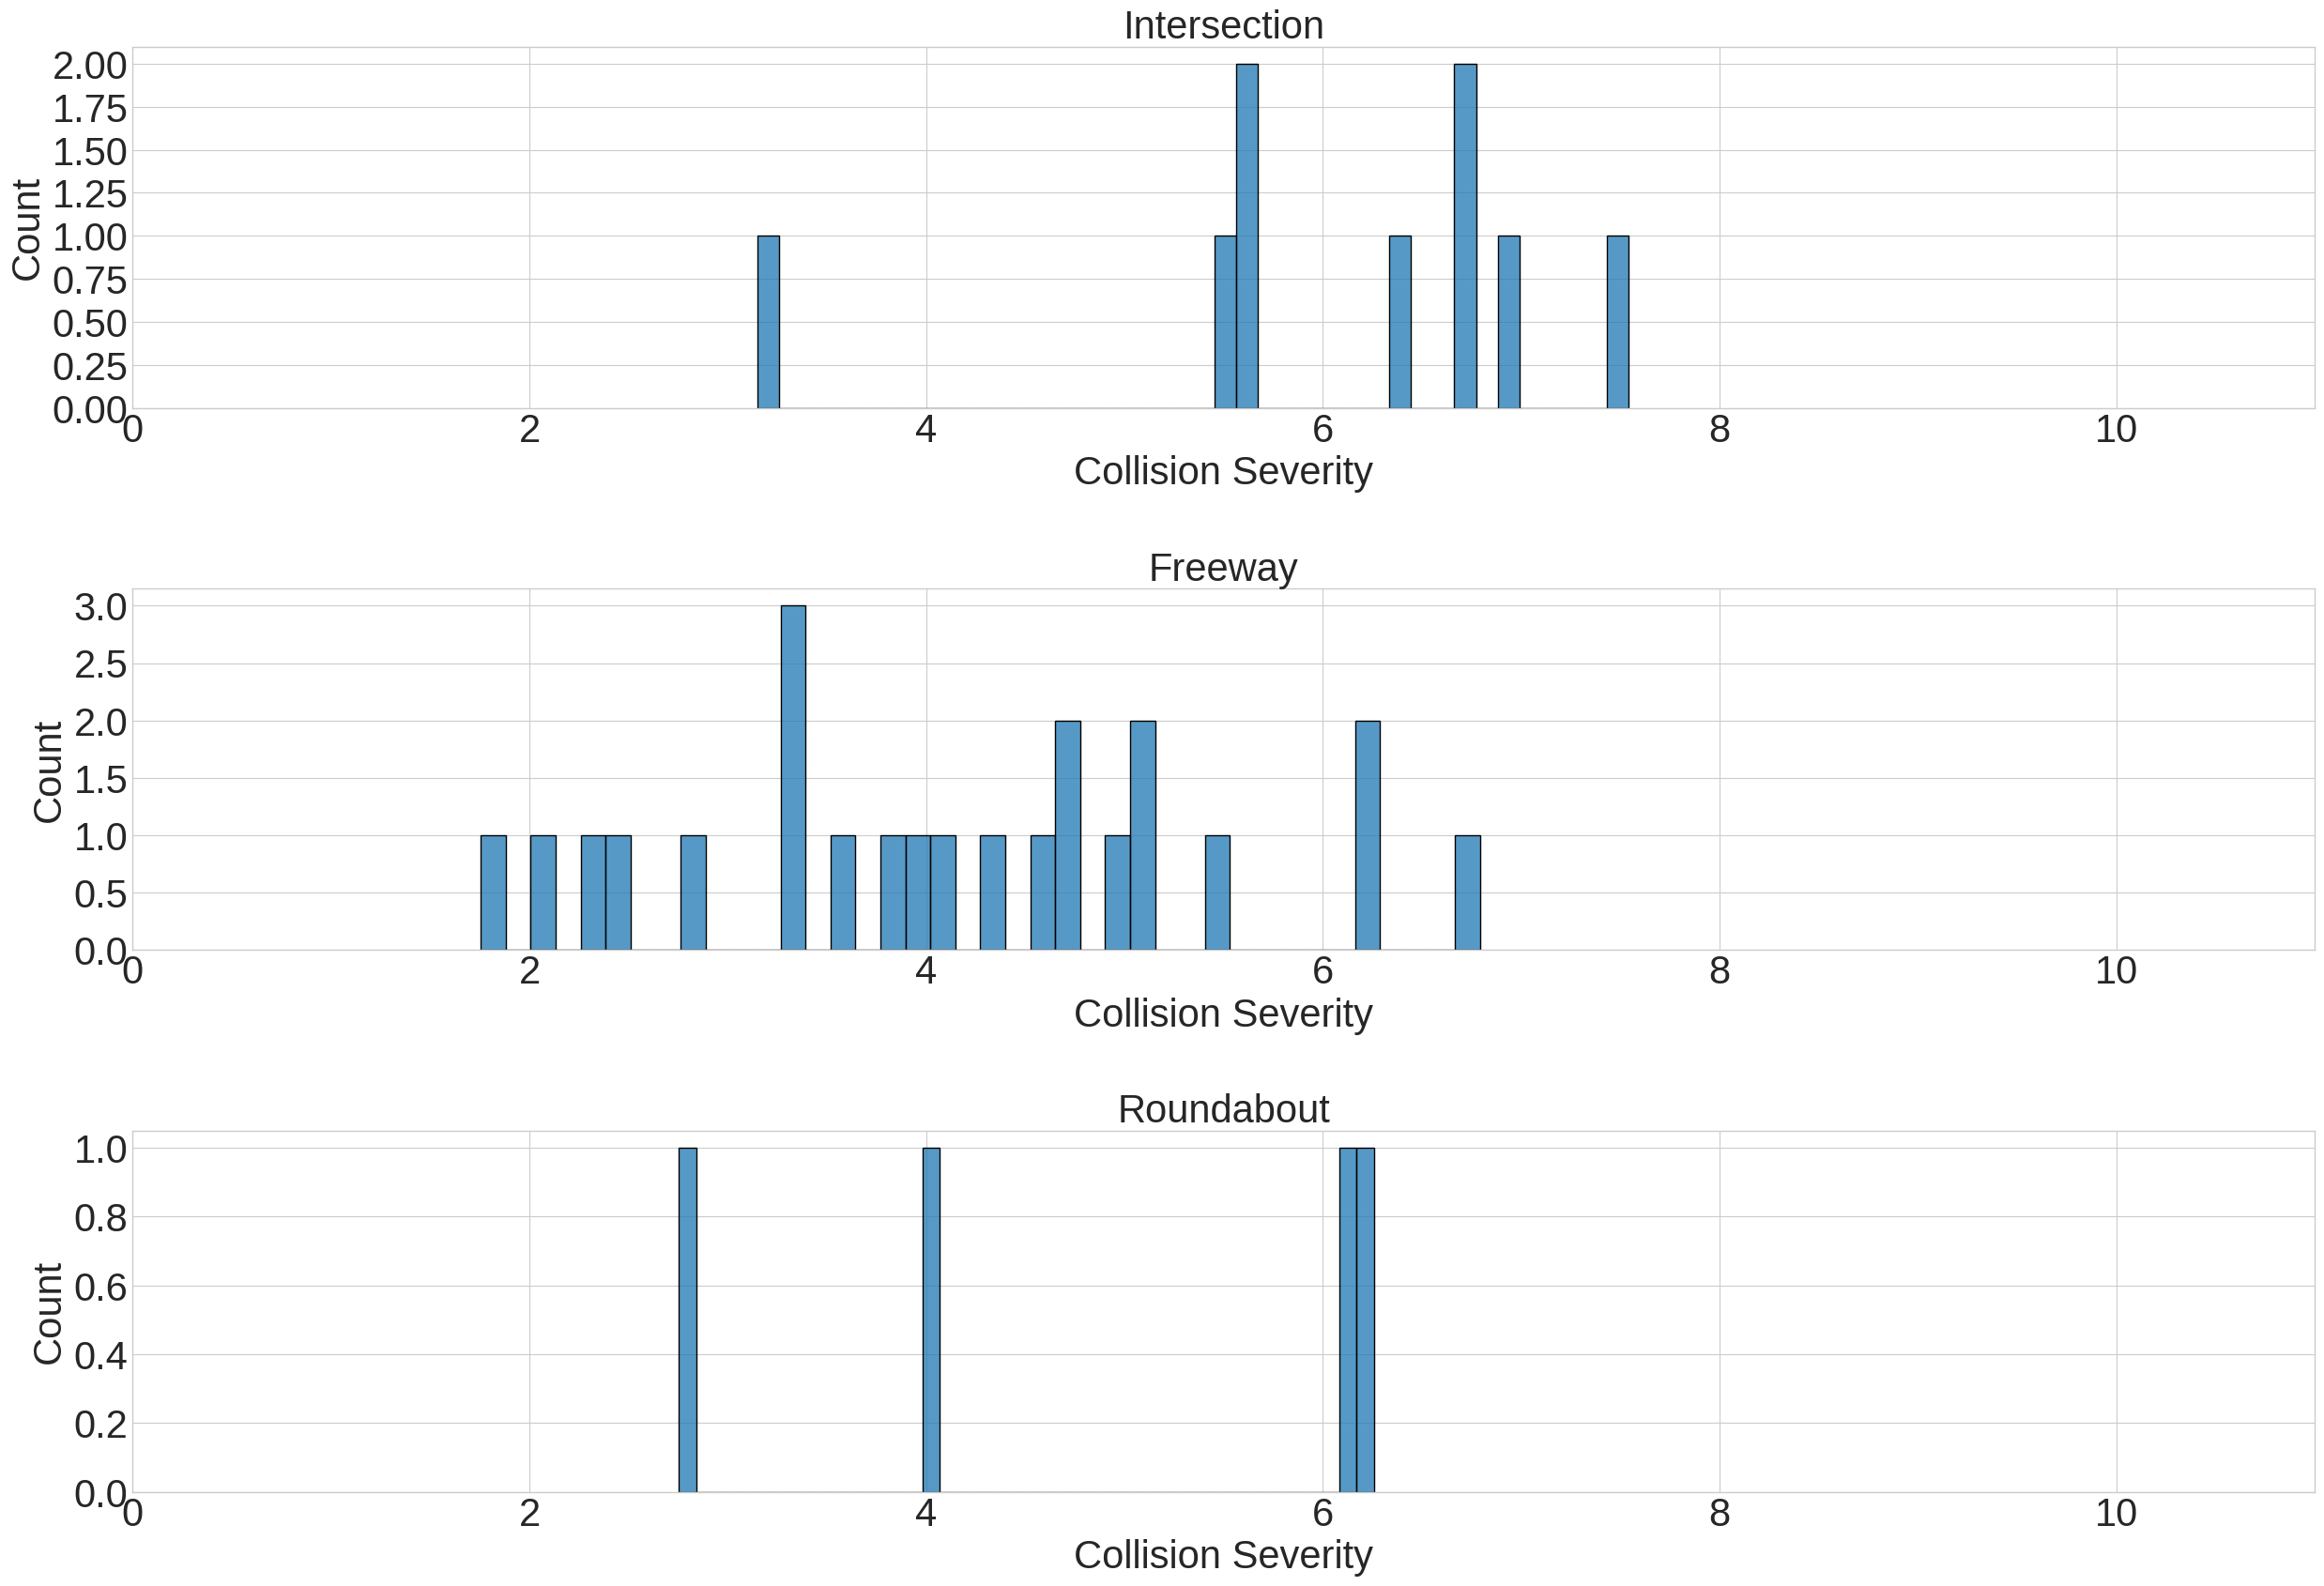

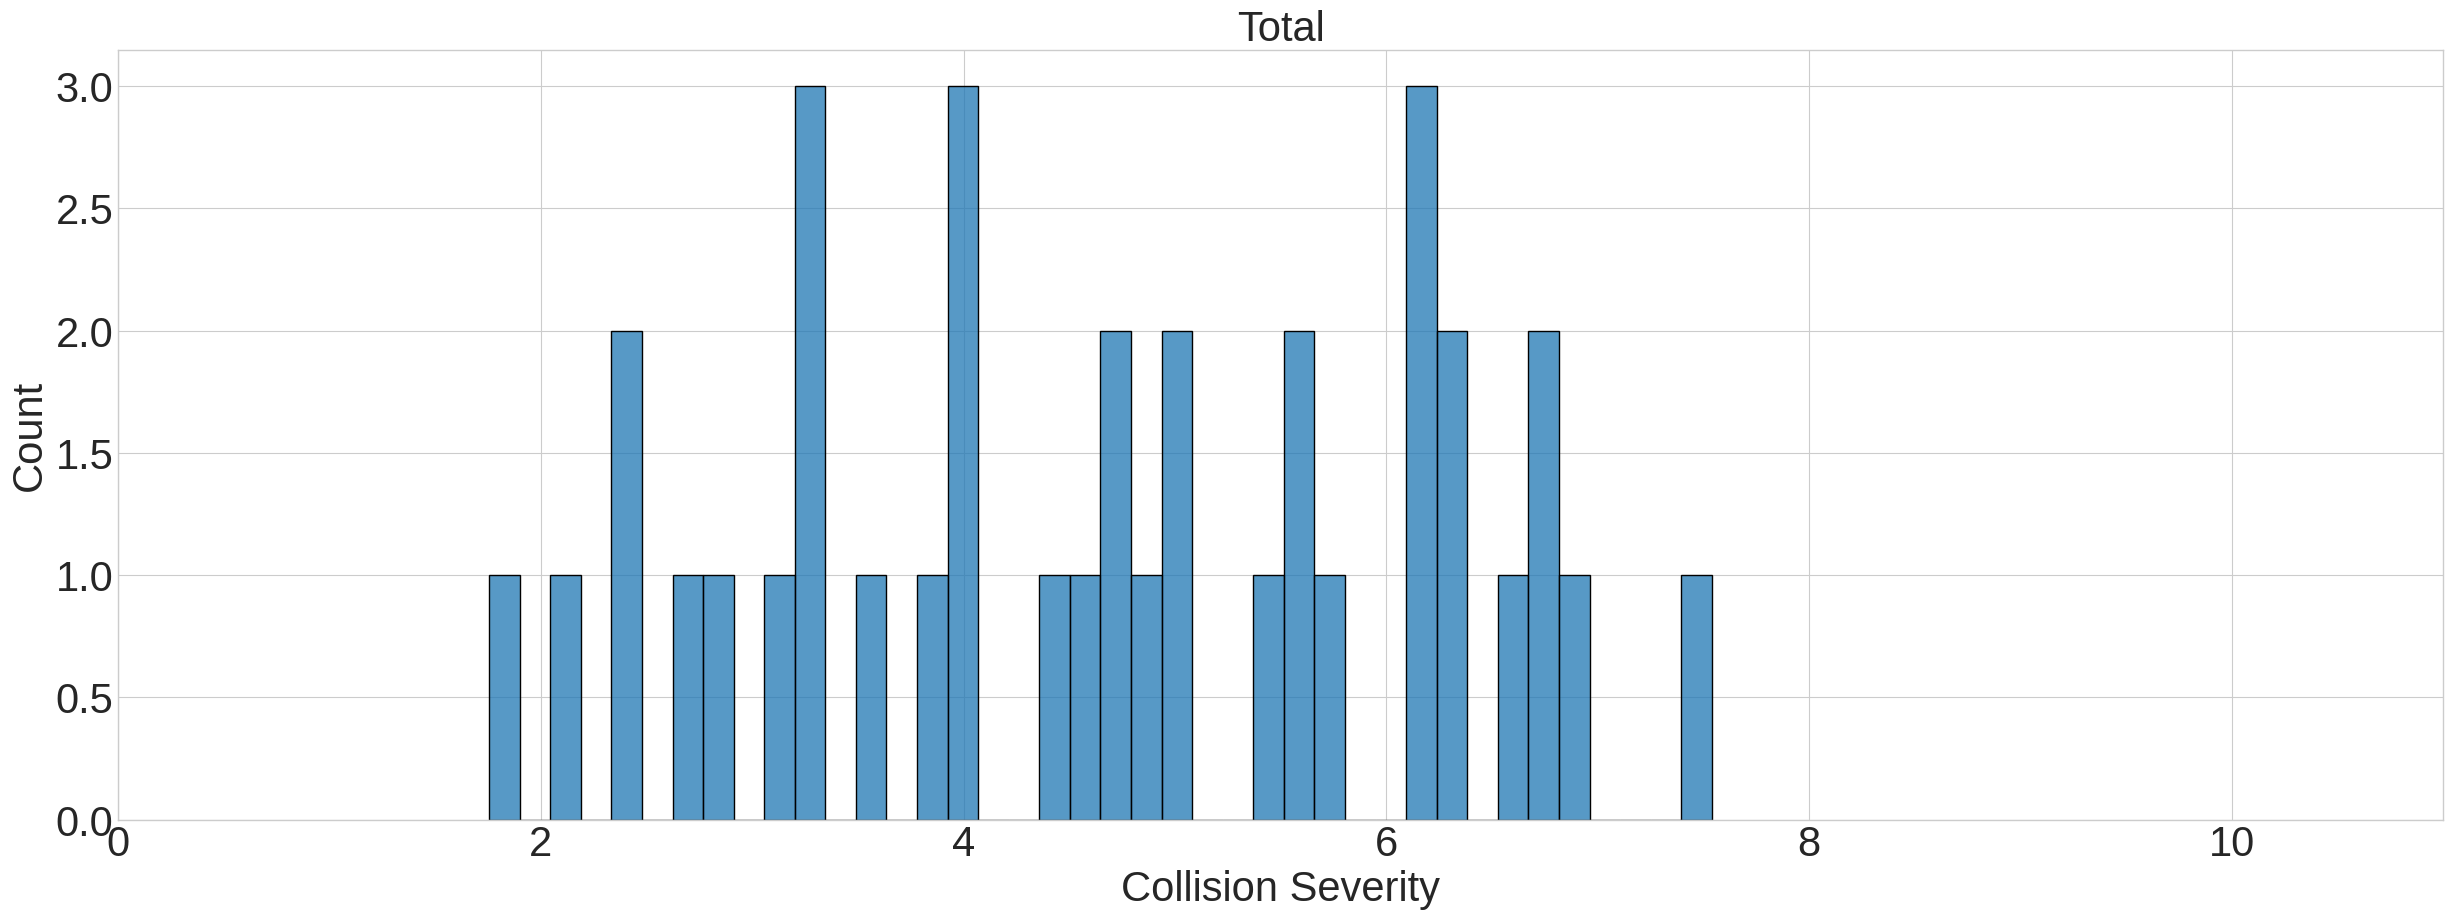

In [173]:
import seaborn as sns

# plot histogram of collision severity
plt.figure(figsize=(30, 20))
plt.subplot(3, 1, 1)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "intersection"], x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Intersection", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 2)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "freeway"], x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Freeway", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 3)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "roundabout"], x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Roundabout", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)

# plot histogram of collision severity in total
plt.figure(figsize=(30, 10))
sns.histplot(data=all_stats_info, x="collision_severity", bins=40)
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Total", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Count", fontsize=30)

Text(0, 0.5, 'Weighted Count')

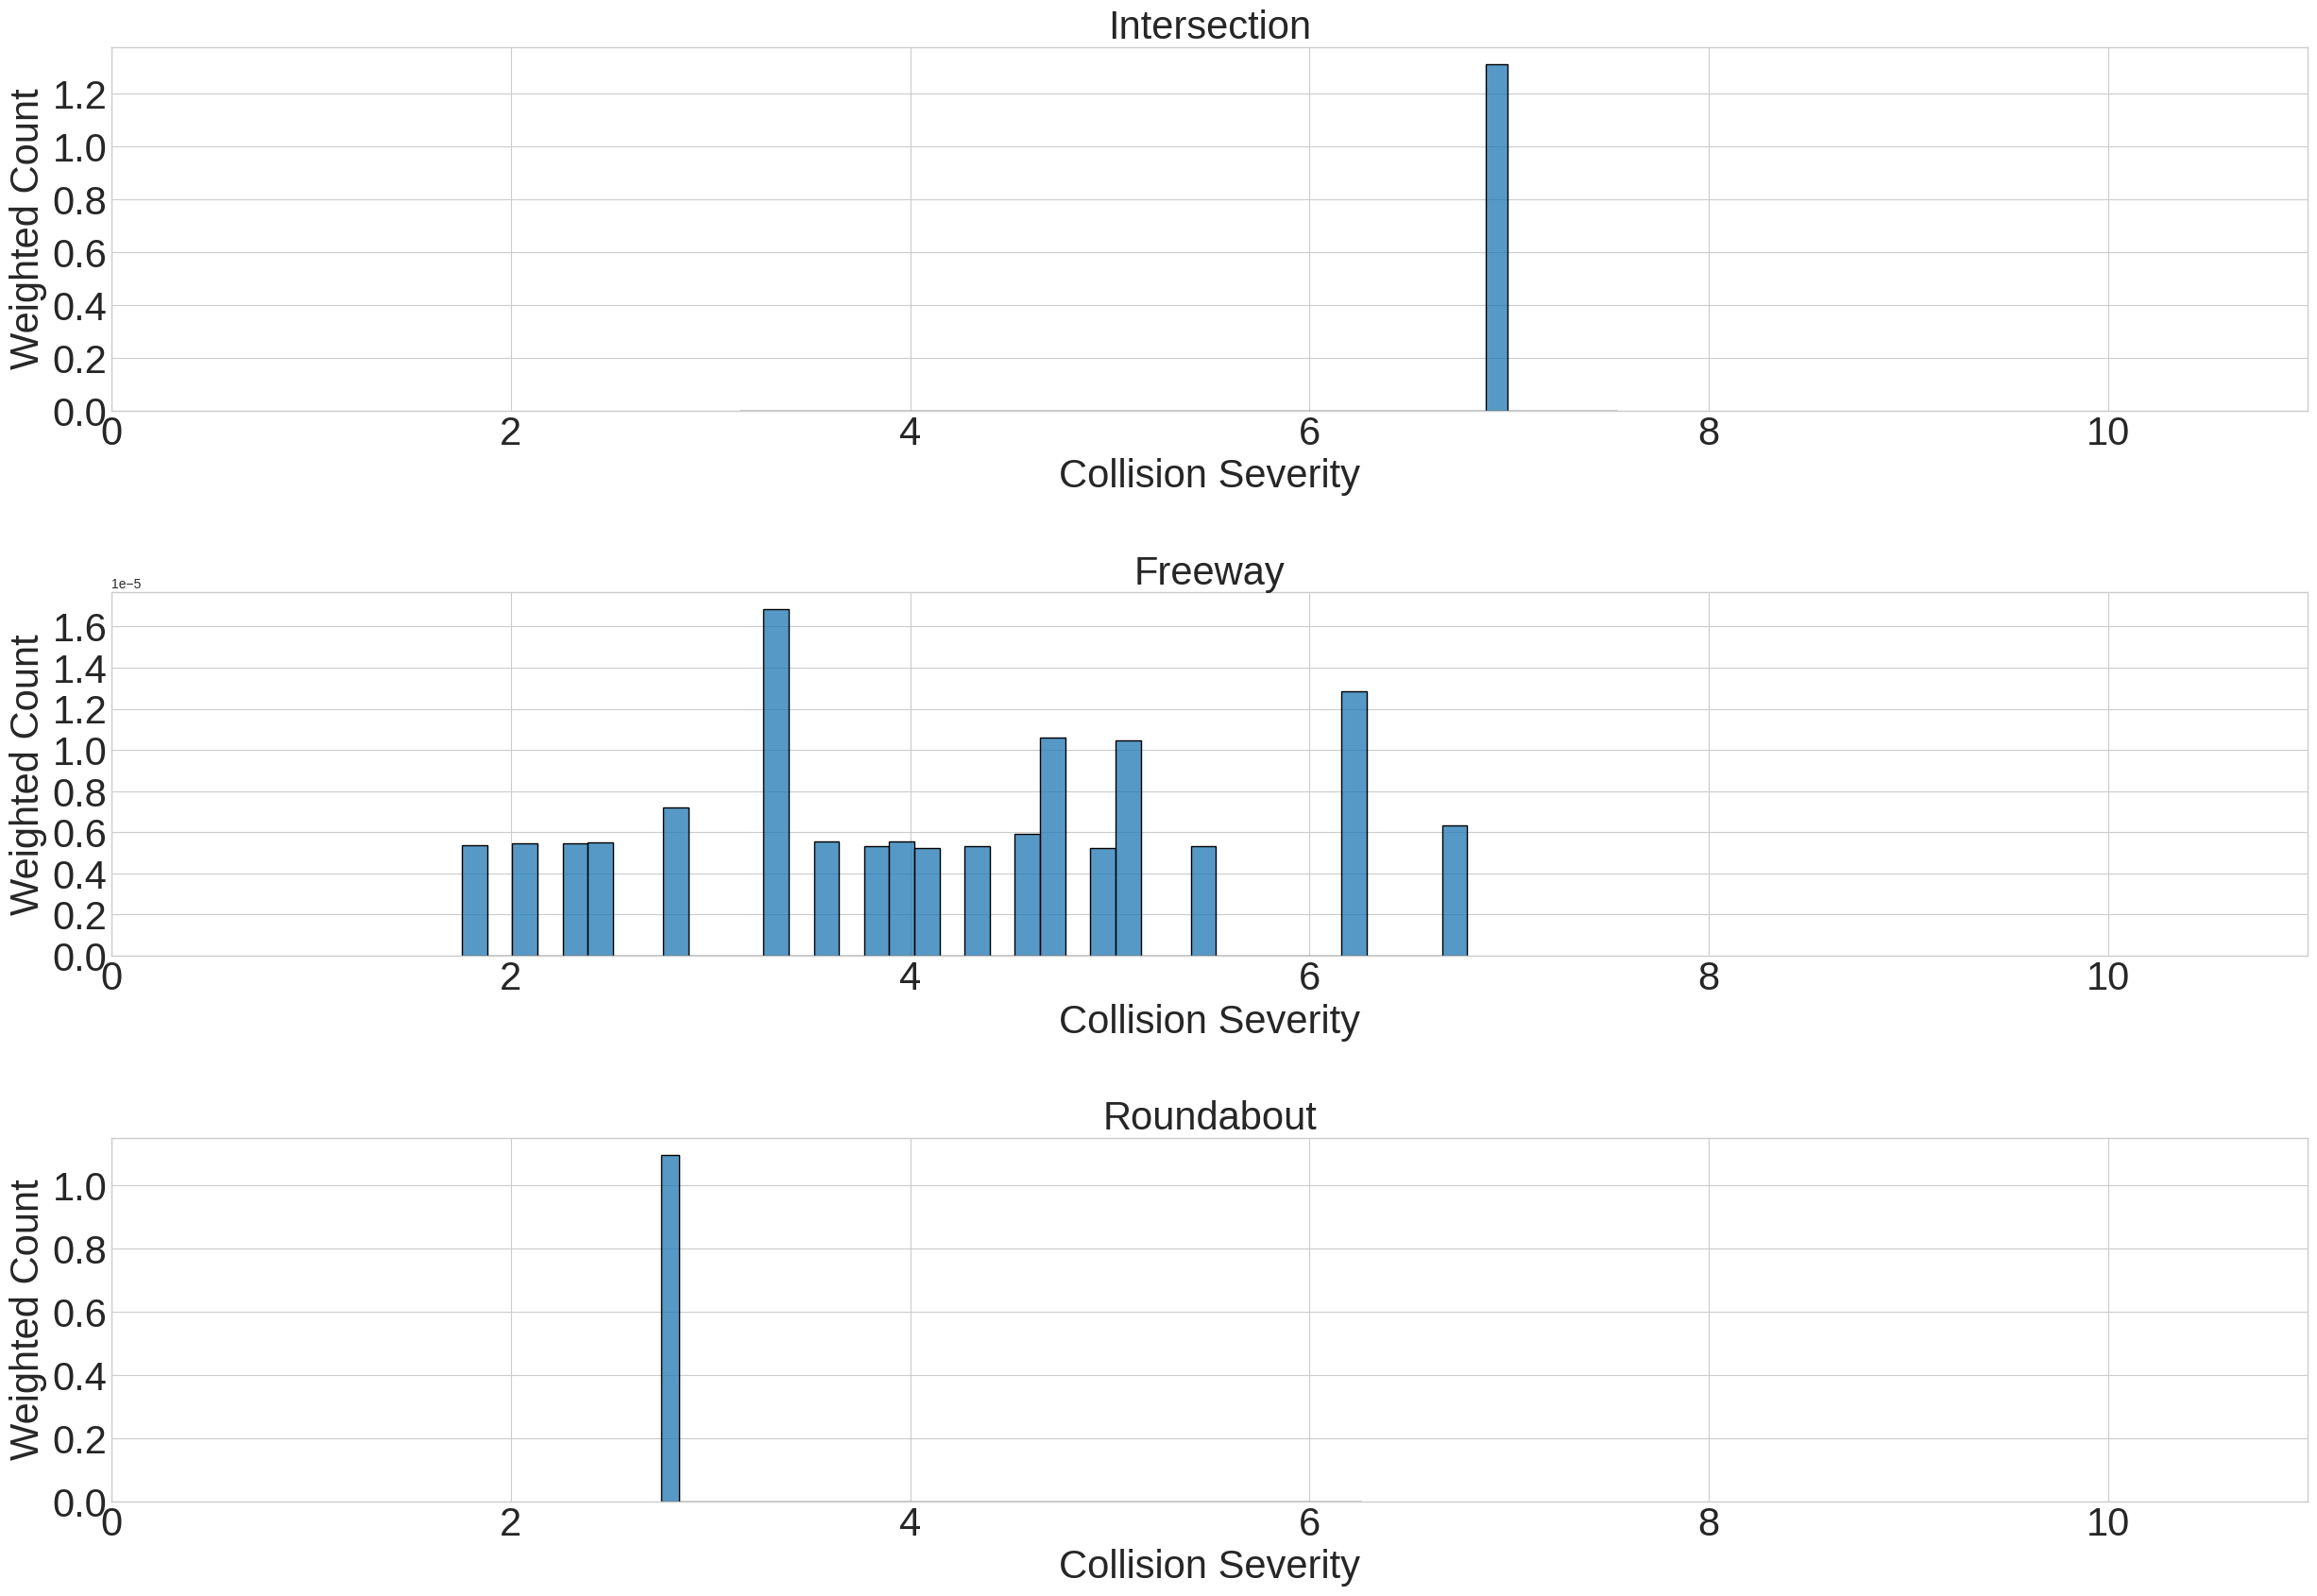

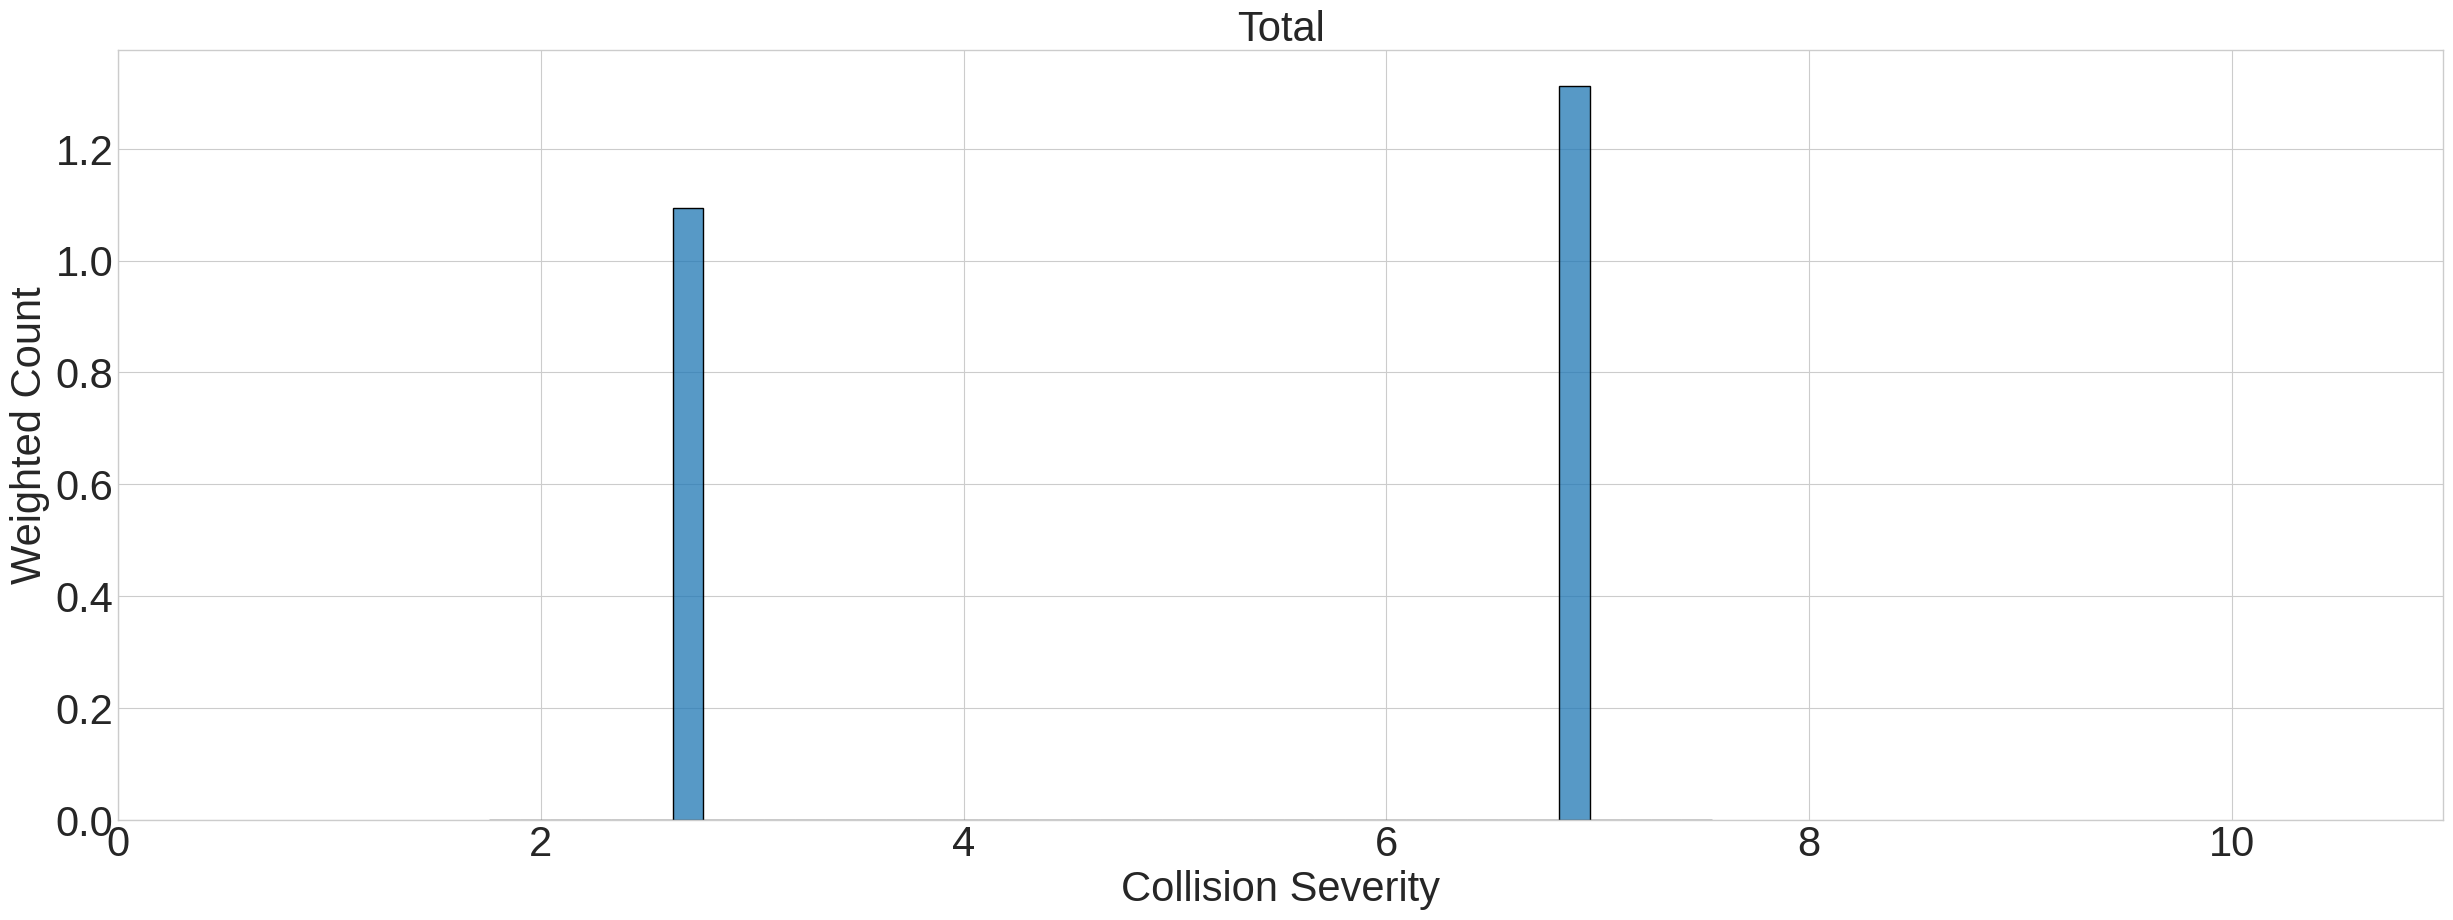

In [174]:
import seaborn as sns
all_stats_info
# plot histogram of collision severity
plt.figure(figsize=(30, 20))
plt.subplot(3, 1, 1)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "intersection"], x="collision_severity", bins=40, weights=all_stats_info[all_stats_info["location"] == "intersection"]["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Intersection", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 2)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "freeway"], x="collision_severity", bins=40, weights=all_stats_info[all_stats_info["location"] == "freeway"]["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Freeway", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)
plt.subplot(3, 1, 3)
sns.histplot(data=all_stats_info[all_stats_info["location"] == "roundabout"], x="collision_severity", bins=40, weights=all_stats_info[all_stats_info["location"] == "roundabout"]["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Roundabout", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)
plt.subplots_adjust(hspace=0.5)

# plot histogram of collision severity in total
plt.figure(figsize=(30, 10))
sns.histplot(data=all_stats_info, x="collision_severity", bins=40, weights=all_stats_info["exp_importance"])
plt.xlim(0, 11)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Total", fontsize=30)
plt.xlabel("Collision Severity", fontsize=30)
plt.ylabel("Weighted Count", fontsize=30)

## Near Miss Analysis

In [175]:
from pathlib import Path
distance_list_dir = Path(export_stat_dir) / "distance_list.npy"
ttc_list_dir = Path(export_stat_dir) / "ttc_list.npy"
# check if the file exists
if not os.path.exists(distance_list_dir) or not os.path.exists(ttc_list_dir):
    print(export_stat_dir)
    print("Near Miss Data not found, please run the following command to generate the data")
else:
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    distance_list = np.load(distance_list_dir)
    ttc_list = np.load(ttc_list_dir)
    plt.figure(figsize=(30, 10))
    sns.histplot(data=distance_list, bins=100)
    plt.title("Distance Distribution", fontsize=30)
    plt.xlabel("Distance (m)", fontsize=30)
    plt.ylabel("Count", fontsize=30)
    plt.xlim(0, 10)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.savefig(f"{export_stat_dir}/distance_distribution.png")
    plt.figure(figsize=(30, 10))
    sns.histplot(data=ttc_list, bins=100)
    plt.title("TTC Distribution", fontsize=30)
    plt.xlabel("TTC (s)", fontsize=30)
    plt.ylabel("Count", fontsize=30)
    plt.xlim(0,5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.savefig(f"{export_stat_dir}/ttc_distribution.png")

/home/zhijie/terasim/TeraSim-NDE-ITE/output/cosim_test_local/processed_data
Near Miss Data not found, please run the following command to generate the data


### Quick check

In [176]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name      
              nunique first
lane_id                    
:NODE_18_15_0       1  1072
:NODE_22_3_0        1   947

#### Export the checklist

In [177]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

### Generate videos in the check list

In [178]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [179]:
import pathlib
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            experiment_record_repo = f"{exp_repo}/{exp_name}"
            exp_id = line.strip()
            # path_name = os.path.join(experiment_record_repo, exp_id)
            experiment_record_repo = pathlib.Path(experiment_record_repo)
            # locate the folder under experiment_record_repo with the name exp_id
            path_name = list(experiment_record_repo.glob(f"**/{exp_id}"))[0]
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                # print(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                # location_type, collision_type = "None", 'None'
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

In [181]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{exp_name}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

# export_videos(f"{export_path}", non_neg_check_list_path)
export_videos(f"{export_path}", neg_caused_check_list_path)

  0%|          | 0/33 [00:00<?, ?it/s]


IndexError: list index out of range

### See README-viz.md for visualization

In [33]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

array([], dtype=object)

In [34]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()

array([':NODE_22_1_0', 'EG_9_1_1_0'], dtype=object)